<h1>TWITTER SENTIMENT ANALYSIS</h1>

<h2>INTRODUCTION</h2>

Gabapentinoids are drugs that are derivatives of the inhibitory neurotransmitter gamma-Aminobutyric acid (GABA) (i.e., GABA analogues). Citing the FDA website: "Gabapentinoids are FDA-approved to treat a variety of conditions including partial seizures and nerve pain from spinal cord injury, shingles, and diabetes. Other approved uses include fibromyalgia and restless legs syndrome. Gabapentin was first approved in 1993 and pregabalin was first approved in 2004. Gabapentin is marketed under the brand names Neurontin and Gralise, and also as generics. Gabapentin enacarbil is marketed under the brand name Horizant. Pregabalin is marketed under the brand names Lyrica and Lyrica CR, and also as generics. Pregabalin is a Schedule V controlled substance, which means it has a lower potential for abuse among the drugs scheduled by the Drug Enforcement Administration (DEA), but may lead to some physical or psychological dependence."

Apart from the uses that are FDA-approved, gabapentinoids are widely prescribed for many off-label uses: all kinds of pain, bipolar disorder, anxiety, depression, insomnia, endometriosis, hot flushes... and are considered a safe alternative to opioids. They are also prescribed to pets. 

For many people, gabapentinoids are 'miracle drugs' and 'godsends'. For many people (including myself), they are ineffective and have many side effects and adverse reactions. That's the reason why I'm going to try to perform a sentiment analysis on tweets that mention these drugs.

<h2>DATA</h2>

<h3>Data Gathering</h3>

To gather the tweets I've used the twint library and the nest_asyncio library. That's the code that I used to gather tweets that mention 'gabapentin':

In [ ]:
import twint
import nest_asyncio
nest_asyncio.apply()

c = twint.Config()

c.Search = ['gabapentin']       # topic
c.Limit = 5000    # number of Tweets to scrape
c.Store_csv = True       # store tweets in a csv file
c.Output = "gabapentin.csv"     # path to csv file

twint.run.Search(c)

I repeated the same process with the terms 'gabapentinoids', 'neurontin', 'pregabalin' and 'Gralise'. I also tried to gather tweets with the terms 'Lyrica' and 'Horizant' but I got mostly song lyrics and tweets in german.

<h3>Data Cleaning and Preprocessing</h3>

First, we import all the necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import preprocessor as p
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
from textblob import TextBlob
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.data import Sentence
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
from PIL import Image
from flair.models import TextClassifier
from flair.data import Sentence
from segtok.segmenter import split_single

pd.set_option('display.max_columns', None)

pd.set_option('display.max_colwidth', None)

We create a list with all the csv files to join together in a single dataframe:

In [2]:
csv_files = ['gabapentin.csv', 'gabapentinoids.csv', 'pregabalin.csv', 'neurontin.csv', 'gralise.csv']

tweets = []

for filename in csv_files:
    data = pd.read_csv(filename, encoding='utf-8')
    tweets.append(data)
    
tweets = pd.concat(tweets)

tweets.shape

(18824, 36)

Next, we drop duplicated tweets

In [3]:
tweets.drop_duplicates(subset='tweet', inplace=True)

tweets.shape

(16133, 36)

We check the info of the dataframe

In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16133 entries, 0 to 1549
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               16133 non-null  int64  
 1   conversation_id  16133 non-null  int64  
 2   created_at       16133 non-null  object 
 3   date             16133 non-null  object 
 4   time             16133 non-null  object 
 5   timezone         16133 non-null  int64  
 6   user_id          16133 non-null  int64  
 7   username         16133 non-null  object 
 8   name             16133 non-null  object 
 9   place            13 non-null     object 
 10  tweet            16133 non-null  object 
 11  language         16133 non-null  object 
 12  mentions         16133 non-null  object 
 13  urls             16133 non-null  object 
 14  photos           16133 non-null  object 
 15  replies_count    16133 non-null  int64  
 16  retweets_count   16133 non-null  int64  
 17  likes_count  

It looks like we have several columns empty or almost empty, so we drop them. Also, we need to change 'created_at' to datetime.

In [5]:
tweets.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [6]:
cols = ['place', 'quote_url', 'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt','retweet_id', 'retweet_date', 
        'translate', 'trans_src', 'trans_dest']

tweets = tweets.drop(cols, axis = 1)

tweets['created_at'] = pd.to_datetime(tweets['date'] + ' ' + tweets['time'])

tweets['created_at'].head()

0   2021-06-29 12:45:20
1   2021-06-29 11:21:25
2   2021-06-29 11:20:27
3   2021-06-29 11:08:02
4   2021-06-29 10:34:18
Name: created_at, dtype: datetime64[ns]

We are going to check some columns to see if it's true that they doesn't have null values

In [7]:
tweets['photos'].head()

0    ['https://pbs.twimg.com/tweet_video_thumb/E5C0oqWXIAIqa_R.jpg']
1                                                                 []
2                                                                 []
3                                                                 []
4                                                                 []
Name: photos, dtype: object

In [8]:
tweets['hashtags'].head()

0    []
1    []
2    []
3    []
4    []
Name: hashtags, dtype: object

We still have null values, and they seem to be represented with brackets, so we replace them with np.nan

In [9]:
tweets = tweets.replace('[]', np.nan)

tweets.isna().sum()

id                     0
conversation_id        0
created_at             0
date                   0
time                   0
timezone               0
user_id                0
username               0
name                   0
tweet                  0
language               0
mentions           15166
urls               12367
photos             14893
replies_count          0
retweets_count         0
likes_count            0
hashtags           14033
cashtags           15844
link                   0
retweet                0
video                  0
reply_to            8612
dtype: int64

We have more columns that are almost empty. Before we drop them, we check other columns to see if they have useful information.

In [10]:
tweets.timezone.value_counts()

200    16133
Name: timezone, dtype: int64

we decide to keep the next columns:

In [11]:
cols = ['id', 'conversation_id', 'created_at', 'date', 'time','user_id', 'tweet', 'language', 'replies_count', 
        'retweets_count', 'likes_count']

tweets = tweets[cols]

tweets.head(2)

,id,conversation_id,created_at,date,time,user_id,tweet,language,replies_count,retweets_count,likes_count
0,1409825305607426052,1409825305607426052,2021-06-29 12:45:20,2021-06-29,12:45:20,1119398768934359041,"Pain levels are a bit out of my control today, i'm drowsy due to the Gabapentin painkillers but at least I can nap without worrying too much. &lt;3 Drowsy waff is drowsy. Music and napping feels like a good combination. &lt;3 https://t.co/nS5ndurS6I",en,0,0,1
1,1409804186221309956,1409804186221309956,2021-06-29 11:21:25,2021-06-29,11:21:25,1951365738,州に感染者6人出たからひっさびさのロックダウンでマスクすぐ忘れちゃう〜,ja,0,0,0


We are only interested in tweets in English, so we check the values of the 'languages' column, so we filter the dataframe.

In [12]:
tweets = tweets[tweets['language'] == 'en']

tweets.shape

(13776, 11)

The next step will be cleaning the tweets of mentions, emojis, urls and other features. We use the library preprocessor to do it. 

In [13]:
def preprocess_tweet(row):
    text = row['tweet']
    text = p.clean(text)
    return text

In [14]:
tweets['tweet'] = tweets.apply(preprocess_tweet, axis=1)

tweets[['id', 'tweet']].sample(5)

,id,tweet
896,1362882166447816704,"Gabapentin aka Neurontin, originally an anti epileptic, often prescribed off label. Millions paid out in lawsuits over the years. Lots of side effects and can wreak havoc with your memory. Some can have permanent damage I would not take it"
4818,1388361008419270656,the ritalin and gabapentin fighting for control of my body rn
10,1409832680536121347,Pregabalin for neuropathic pain post covid
2017,1055061658828189696,"Evan Kharasch presenting grand rounds on the perioperative use of gabapentinoids. Interesting discussion on pharmacologic goals of multimodal analgesia Gabapentinoids mildly decrease pain but similarly increase adverse events. Thus, no net benefit."
4953,1387762926631665667,"This likely doesn't relate to you, but a variety of psychiatric medications increase the intensity of dreams -- some people say it's like going to the movies at night. Sleep aids like gabapentin and melatonin don't do that as often."


Now, let's set 'created_at' as the column index of the dataframe and sort the values.

In [15]:
tweets = tweets.set_index('created_at')

tweets.sort_index(inplace=True)

tweets[['id', 'tweet']].sample(5)

,id,tweet
created_at,,
2021-05-27 16:58:40,1397930258360242180,"Saskatchewan Physicians Opinions of Their Personalized Prescribing Profiles Related to Opioids, Benzodiazepines, Stimulants, and Gabapentin | Journal of Medical Regulation"
2021-06-02 23:27:48,1400202513286983681,"Bc obv the Lyrica Ive been on for &gt;yr for fibromyalgia means I need therapy. If I switched to gabapentin, though, then I wouldnt need to go to an entire separate therapy appointment. That makes total sense &amp; is def not an arbitrary barrier to treatment at all! /s"
2018-07-03 15:01:01,1014131902809300993,"Currently recommends gabapentinoids, amitriptylline or duloxetine for neuropathic pain. Shame the meta-analysis didn't look at amitriptylline and duloxetine as well to complete the Bonfire of the Pain Modulators."
2021-06-13 05:14:00,1403913518752014336,Yes we did. The double dose of gabapentin seems to be working well. Hooray. xxx
2014-09-07 16:39:45,508625673896722432,true. This outcome was severely delayed by DC Judge.She waited until after Gralise patent ruling so as to mitigate political risk


The next step in the cleaning process is put all the tweets in lowercase, eliminate punctuation and extra whitespaces, and change 'amp' for 'and.

In [16]:
tweets['tweet'] = tweets['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ').str.replace('amp', 'and')

tweets[['id','tweet']].sample(5)

,id,tweet
created_at,,
2021-06-01 16:21:31,1399732850488926212,i suffer from acute sciatica and take tramadol gabapentin and amatryptaline i also use biofreeze which helps freeze around the painful area during the summer i use reusable cold gel packs which you put in the freezer for an hour or so and then wrap it in a tea towel then apply
2019-12-24 15:24:49,1209480047377170432,where is the evidence to show this please i was rx frisium for epilepsy not by maudsley but by a neuro hospital so what u do at maudsley is irrelevant to me no offence do u rx lyrica neurontin
2021-06-19 14:52:11,1406233346619891712,i ve been on pregabalin for many years side effects weren t bad and mostly related to acute ones that go away like drowsiness euphoria feeling drunk dizzyness dry mouth fatigue sleepiness increased or decreased apetite there s some serious ones but most don t get em
2019-07-19 05:30:51,1152058191368396801,no i also take neurontin zanaflex and diclofenac id be in knots without them
2021-05-01 15:31:29,1388486234104860675,add me to the list of people suggesting you talk to your neurologist about switching meds i tell people gabapentin made me fat and stupid i gained a ton of weight and couldn t remember words and i m an editor see if you can try another drug duoloxetine maybe


I've realized that some tweets don't include any of the search terms, probably because they were hashtags, so I'm going to select only the tweets that contain the terms 'gabapentinoids', 'gabapentin', 'Neurontin, 'lyrica', 'pregabalin', 'gralise' and 'horizant'.

In [17]:
tweets = tweets[tweets['tweet'].str.contains('gabapentinoids|gabapentin|neurontin|lyrica|pregabalin|gralise|horizant')]

tweets[['id', 'tweet']].sample(5)

,id,tweet
created_at,,
2019-06-06 12:24:55,1136579713953140736,pfizer s done so many terrible things they made a fortune pushing meds to drs and lying about their successful off label uses google neurontin for one of the stories
2020-09-07 20:47:36,1303042250633404416,i ve been practicing staying mindful of my heart rate when i m exerting myself lots more practice required this all started after brain injury it got a bit better when i got off gabapentin neurontin but it s as predictable as old faithful
2017-05-18 14:24:05,865181194765447168,see the link below regarding gabapentinoids and their increasing link with drug related deaths
2021-06-28 23:14:06,1409621152465506304,i took a gabapentin last night and slept until pm
2020-03-19 14:36:32,1240633255755423744,eh sorta it s does a mediocre job some docs r saying the newer versions work better gralise some docs also like to stack gabapentin w lyrica since they work differently on the brain some people incld myself find the stacking works very well but some ppl exp weird


The next steps in the process are tokenization and removal of stopwords, we use the nltk library

In [18]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
def identify_tokens(row):
    tweet = row['tweet']
    tokens = nltk.word_tokenize(tweet)
    return tokens

tweets['clean_tweet'] = tweets.apply(identify_tokens, axis=1)

tweets[['id', 'tweet', 'clean_tweet']].sample(5)

,id,tweet,clean_tweet
created_at,,,
2021-06-27 04:42:40,1408979060634669056,gabapentin and xanax is the only way i can get on a plane,"[gabapentin, and, xanax, is, the, only, way, i, can, get, on, a, plane]"
2019-05-26 06:32:37,1132504790863187969,i had to take gabapentin neurontin for chronic nerve pain related to sciatica then i couldnt sleep so then my doctor prescribed ambien then i was a cranky zombie,"[i, had, to, take, gabapentin, neurontin, for, chronic, nerve, pain, related, to, sciatica, then, i, couldnt, sleep, so, then, my, doctor, prescribed, ambien, then, i, was, a, cranky, zombie]"
2021-06-25 22:57:50,1408529891599863810,good day sue husband woke me up at had terrible night with spasms remembered i had neurontin which helped at first thought it was caused by nice shoes totally new found in thrift made in west germany atreasure husband made credible baguettes while i slept,"[good, day, sue, husband, woke, me, up, at, had, terrible, night, with, spasms, remembered, i, had, neurontin, which, helped, at, first, thought, it, was, caused, by, nice, shoes, totally, new, found, in, thrift, made, in, west, germany, atreasure, husband, made, credible, baguettes, while, i, slept]"
2021-05-01 15:53:48,1388491847459381248,gabapentin is not for pain at all it is only for i know st hand the side affects for using gabapentin for pain are horrible and many lawsuits have occurred under doctors care slowly ween your self off as one cannot just stop as it may cause a brain seizure and you could die,"[gabapentin, is, not, for, pain, at, all, it, is, only, for, i, know, st, hand, the, side, affects, for, using, gabapentin, for, pain, are, horrible, and, many, lawsuits, have, occurred, under, doctors, care, slowly, ween, your, self, off, as, one, can, not, just, stop, as, it, may, cause, a, brain, seizure, and, you, could, die]"
2020-06-02 19:25:59,1267870086171373568,already afternoon a broken record that keeps skipping playing over and over and over again day in and day out my wasn t too bad until noon and it s clear the neurontin isn t going to take off the edge this is break through pain i get so sick of the life,"[already, afternoon, a, broken, record, that, keeps, skipping, playing, over, and, over, and, over, again, day, in, and, day, out, my, wasn, t, too, bad, until, noon, and, it, s, clear, the, neurontin, isn, t, going, to, take, off, the, edge, this, is, break, through, pain, i, get, so, sick, of, the, life]"


In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))      

def remove_stops(row):
    my_list = row['clean_tweet']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

tweets['clean_tweet'] = tweets.apply(remove_stops, axis=1)

tweets[['id', 'tweet', 'clean_tweet']].sample(50)

,id,tweet,clean_tweet
created_at,,,
2017-01-11 01:00:18,818970757556563969,regulatory news fda drug approvals changes for tuesday january children s motrin gralise phenytoin and more,"[regulatory, news, fda, drug, approvals, changes, tuesday, january, children, motrin, gralise, phenytoin]"
2021-05-16 20:57:41,1394004144118140928,gabapentin i think we ve officially broken up,"[gabapentin, think, officially, broken]"
2021-06-10 04:37:33,1402817181830680584,i made the executive decision to ghost my psychiatrist for the rest of time so i am forced to stop taking adderall and gabapentin,"[made, executive, decision, ghost, psychiatrist, rest, time, forced, stop, taking, adderall, gabapentin]"
2021-05-12 18:13:03,1392513160733732868,i know my a quit because she couldn t get her gabapentin for her pain so that she could work because the government decided that people shouldn t have gabapentin paid by their insurance so she didn t get her gabapentin so she quit her job i m almost positive that s what happened,"[know, quit, get, gabapentin, pain, could, work, government, decided, people, gabapentin, paid, insurance, get, gabapentin, quit, job, almost, positive, happened]"
2019-12-09 00:41:28,1203821927980158981,neurontin and lyrica are a death sentence for new brain synapses,"[neurontin, lyrica, death, sentence, new, brain, synapses]"
2021-03-11 08:13:02,1369909213774962692,i dm d it being a diabetic on it at same time as neurontin making me even extra forgetful was super rough at first the continuous meter borg device protects me now but my aussies did it for me for years,"[dm, diabetic, time, neurontin, making, even, extra, forgetful, super, rough, first, continuous, meter, borg, device, protects, aussies, years]"
2012-04-23 03:38:54,194238889546887168,gralise coupons,"[gralise, coupons]"
2021-05-26 20:15:58,1397617524548767749,gabapentin mg a day,"[gabapentin, mg, day]"
2019-08-31 18:07:23,1167831257151135744,i ve been on neurontin the brand version of gabapentin now going to have to move to generic which does not work the same,"[neurontin, brand, version, gabapentin, going, move, generic, work]"


<h2>EXPLORATORY DATA ANALYSIS</h2>

First of all, let’s look at the oldest and the newest tweets creation time in our data set.

In [22]:
# Print the minimum datetime
print("Since:",tweets.index.min())

# Print the maximum datetime
print("Until",tweets.index.max())

Since: 2011-01-29 01:35:33
Until 2021-07-08 18:34:36


Let's see the distribution of tweets per year

In [23]:
tweets_per_year = tweets['id'].groupby(tweets.index.year).count()

tweets_per_year

created_at
2011     242
2012     279
2013      85
2014     161
2015      73
2016     115
2017     545
2018     479
2019    2533
2020    2101
2021    6181
Name: id, dtype: int64

Most of the tweets were published in the last three years, especially in 2021

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


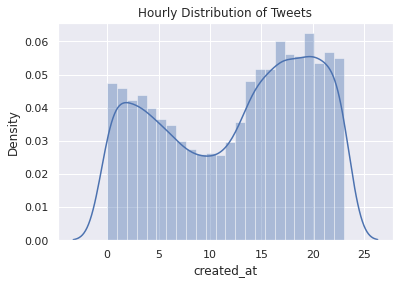

In [24]:
# Set the seaborn style
sns.set()
# Plot the histogram of hours
sns.distplot(tweets.index.hour, bins=24)
plt.title("Hourly Distribution of Tweets")
plt.show()

Next, let's display the tweets with more likes.

In [25]:
display(tweets.sort_values(by=["likes_count", ], axis=0, ascending=False)[["tweet","likes_count"]].head(10))

,tweet,likes_count
created_at,,
2021-04-07 13:15:18,absolutely agree patients need to be managed away from opioids gabapentinoids so nice can you mandate that the govt set ups more pain clinics recruits more psychologists physios ots etc without that gps and patients are stuck,374
2021-06-04 02:48:55,this asshole got mg gabapentin and was still so violent at the vet that they couldnt get him out of his carrier they want me to reschedule and give mg of gabapentin next time freaking punk,248
2021-04-23 06:26:34,for some reason tobiass default state is him with his tongue out during the hours that hes pretty exhausted from gabapentin i have to always check that his tongue isnt hanging out even touching it doesnt make him put it back in,228
2019-09-24 22:21:58,mechanism of pregabalin gabapentin pregabalin lyrica and gabapentin neurontin are structural analogs of gaba but they do not work by interacting with gaba instead both drugs act as inhibitors of subunit containing voltage dependent calcium channels vdccs,205
2021-06-07 20:14:33,we also tried daily gabapentin first then elavil as non opiate pain control options neither of them worked last week i started him on a stronger long acting opiate twice a day i would be lying if i didn t admit i was questioning whether i was doing the right thing,179
2021-05-13 04:26:16,hi pals fanks fer all prayers n well wishes ive been home about hours n finally getting comfy wif da gabapentin da nice vet dogtor said everyfing went well today n i should be chasing critters by mid july yahooo aroooo,179
2019-09-10 15:11:25,opioid painkillers for acute pain and injury excluding use in cancer patients only cancer patients have long term pain i must be imagining mine gabapentinoids used to treat epilepsy anxiety and nerve related pain do you think these things just magically go away,170
2021-06-22 02:45:18,older adults receiving gabapentinoids are at risk of experiencing a potentially harmful prescribing cascade peripheral edema leading to diuretic use rather than discontinuing or reducing the dose of the gabapentinoid,156
2020-04-29 12:47:40,new article on pregabalin and gabapentin for pain no evidence for the use of gabapentinoids to improve pain in sciatica low back pain and other off label use conditions,153


Tweets with more retweets

In [26]:
display(tweets.sort_values(by=["retweets_count", ], axis=0, ascending=False)[["tweet","retweets_count"]].head(10))           

,tweet,retweets_count
created_at,,
2017-08-16 12:02:40,gabapentinoids should not be used for chronic low back pain meta analysis concludes,99
2019-09-24 22:21:58,mechanism of pregabalin gabapentin pregabalin lyrica and gabapentin neurontin are structural analogs of gaba but they do not work by interacting with gaba instead both drugs act as inhibitors of subunit containing voltage dependent calcium channels vdccs,86
2021-02-08 18:10:56,in pfizers subsidiary warner lambert was fined 430 million to resolve criminal charges and civil liabilities for the fraudulent promotion of its epilepsy drug neurontin paying and bribing doctors to prescribe it for uses not approved by the fda,85
2021-04-21 17:05:44,neurontin gabapentin is being used widely in us now uk how well does it work for your pain next tweet side effects retweet please,82
2020-04-29 12:47:40,new article on pregabalin and gabapentin for pain no evidence for the use of gabapentinoids to improve pain in sciatica low back pain and other off label use conditions,79
2020-11-06 19:42:04,summary of buddys monthly expenses if we have a vet housecall 160 to arrive at door all else extra neurontin trazadone tramadol rimadyl 80 month in dasuquin 120 140 pee pads 180 in nutri,69
2021-04-07 13:15:18,absolutely agree patients need to be managed away from opioids gabapentinoids so nice can you mandate that the govt set ups more pain clinics recruits more psychologists physios ots etc without that gps and patients are stuck,65
2020-06-30 14:45:24,new study found that in a meta analysis of randomized controlled trials comparing gabapentinoids with controls no clinically meaningful difference in acute subacute or chronic pain was observed,61
2020-07-05 04:04:59,time to rethink the perioperative use of gabapentinoids no clinically meaningful difference in acute subacute or chronic in meta analysis of rcts also adverse events like dizziness and visual disturbance,58


Tweets with more replies

In [27]:
display(tweets.sort_values(by=["replies_count", ], axis=0, ascending=False)[["conversation_id", "tweet","replies_count"]].head(10))

,conversation_id,tweet,replies_count
created_at,,,
2021-05-28 07:16:44,1398146196116496387,what do you know about gabapentin,113
2021-05-01 17:01:50,1388508970801897476,if you have nerve damage in your feet for instance what long term prescription medications other than gabapentin are you taking for the pain,112
2021-04-21 07:06:39,1384735309309505536,restless legs syndrome people do any of you use gabapentin or pregabalin would you recommend it if so i m due for a treatment review in a few days,86
2021-04-21 17:08:50,1384886854881787905,neurontin gabapentin side effects retweet please did you have problems,74
2021-05-28 15:44:38,1398274016851468290,ok question for anyone who has taken gabapentin for anxiety did you find it effective please only answer if you ve taken gabapentin for anxiety this is the only information i am looking for,70
2021-06-29 10:01:02,1409783956023697410,anybody got experience of amatriptyline 10mg mg as a pain medication for neuropathic pain i d love to come off pregabalin,65
2021-04-21 17:05:44,1384886074128932866,neurontin gabapentin is being used widely in us now uk how well does it work for your pain next tweet side effects retweet please,54
2021-04-07 13:15:18,1379754654297419777,absolutely agree patients need to be managed away from opioids gabapentinoids so nice can you mandate that the govt set ups more pain clinics recruits more psychologists physios ots etc without that gps and patients are stuck,54
2020-08-03 23:02:48,1290392700479516673,uk nice draft recommendations for chronic do not offer nsaids gabapentinoids local anaesthetics by any route paracetamol ketamine corticosteroids pain management program,46


Next, we are going to create a word cloud with the most common words:

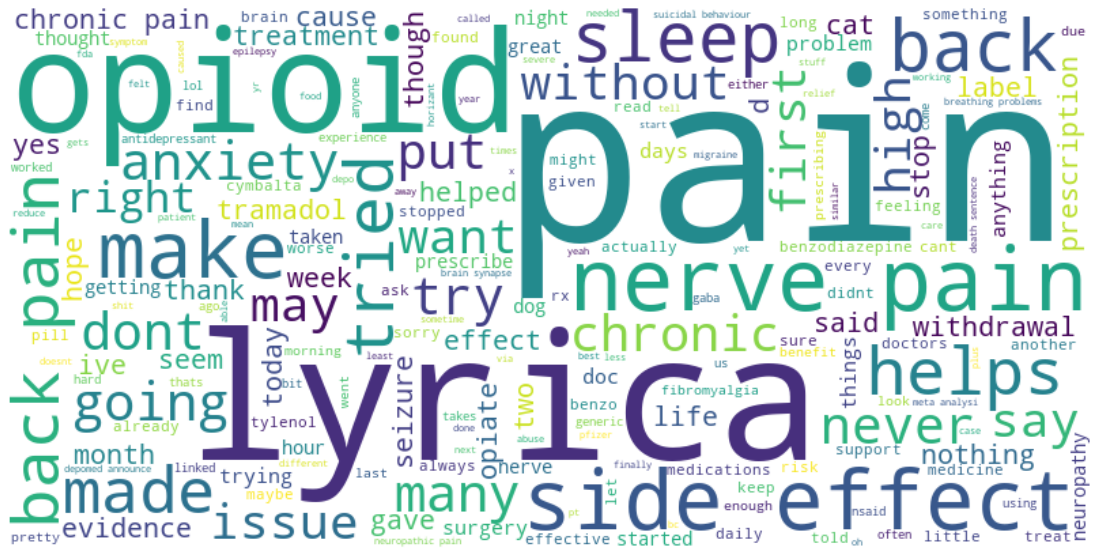

In [28]:
text = " ".join(tweet for tweet in tweets.tweet)

stopwords = set(STOPWORDS)
stopwords.update(["gabapentinoids", "gabapentin", "pregabalin", 'Neurontin', 'gralise', "still", "also", 'get', 'need', 'amp', 'one', 'much',
            'm', 's', 'take', 'drug', 'day', 'med', 've', 'use', 'don', 't', 'mg', 'now', 'help', 'work', 'know', 'good',
            'meds', 'medication', 'Im', 'time', 'like', 'im', 'prescribed', 'drugs', 'used', 'well', 'taking', 'dose', 
             'years', 'got', 'neurontin', 'people', 'think', 'really', 'took', 'would', 'new', 'patients', 'never'
            'tried', 'feel', 'works', 'go', 'even', 'bad', 'low', 'give', 'Dr', 'doctor', 'see', 'will', 'better', 'thing', 
            'u', 'lot', 'way', 're', 'doesn', 'didn', 'll', 'w', 'etc', 'vet', 'ye', 'isn', ])


wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white").generate(text)

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We can see that, although we didn't look for tweets that mention 'lyrica', it's one of the most frequent words. The most frequent terms seem to be 'pain', 'nerve pain' and 'chronic pain'. 'Opioid' is also very frequent, something normal since gabapentinoids are often prescribed as an alternative to them. Other frequent terms are 'side effect', 'withdrawal' and 'anxiety'. 

<h2>SENTIMENT ANALYSIS</h2>

We are going to use different methods and compare the results. The first one is Textblob

In [29]:
tweets['blob_polarity'] = tweets['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

tweets['blob_subjectivity'] = tweets['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.subjectivity)

tweets[['id', "tweet", "blob_polarity","blob_subjectivity"]].sample(10)

,id,tweet,blob_polarity,blob_subjectivity
created_at,,,,
2021-06-19 14:54:24,1406233904722370570,it can cause breathing depression but i m on many similar ones with pregabalin and it works fine the doctor just needs to gauge and increase your dose slowly,0.154167,0.450000
2018-01-18 06:27:07,953861286449893382,with no long term evidence on gabapentinoids and it s theraputic value stopping synaptogenesis gabapentin is often underestimated,0.025000,0.400000
2018-02-15 18:52:02,964195613419212805,evidence based prescribing gabapentinoids long term evidence on topic schedule v is needed tracking doesn t impact scripts,-0.050000,0.400000
2019-12-01 18:39:39,1201194160671383555,i left the local mental health center after their quack psychiatrist didnt even bother to open up my file not even the st page with a huge red sharpie warning that i am deathly allergic w anaphylactic shock of a med neurontin gabapentin off label nerve pain med,0.028571,0.242857
2019-06-11 23:54:25,1138565172216422401,great point about concerns with increased mortality when gabapentinoids are combined with opiates we should all recall that all pain medications come with a risk,0.800000,0.750000
2021-06-27 14:21:09,1409124641847885835,pregabalin and gabapentin to be controlled as class c drugs,0.000000,0.000000
2018-01-31 04:00:14,958535363752026112,gabapentin neurotin lyrica gralise are pain meds for ppl that have chronic severe nerve pain no theyre not opioids but for ppl like me that have tn on ddd ms ect gabapentin meds can mean the diff betw our pain level being a or a,-0.312500,0.687500
2019-10-29 10:44:46,1189115852550885377,new post gabapentinoids appear increasingly to be prescribed off label for cancer pain has been published on oncology news australia,0.136364,0.454545
2017-08-15 20:40:17,897528386666496000,evidence does not support the use of gabapentinoids for chronic low back pain,0.000000,0.150000


Let's categorize the values:

In [30]:
def analyse_polarity(polarity):
    if polarity > 0:
        return "Positive"
    if polarity == 0:
        return "Neutral"
    if polarity < 0:
        return "Negative"

tweets["blob_sentiment"] = tweets["blob_polarity"].apply(analyse_polarity)

tweets["blob_sentiment"].value_counts()

Positive    5337
Neutral     3858
Negative    3599
Name: blob_sentiment, dtype: int64

It looks like more tweets are positive, let's see a graphic representation

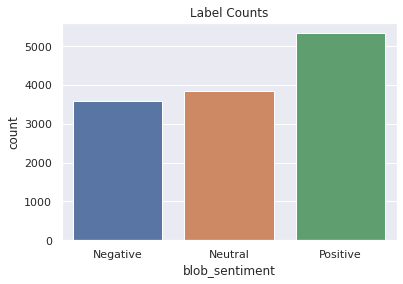

In [31]:
tweets["blob_sentiment"] = tweets["blob_sentiment"].astype("category")

sns.countplot(x=tweets["blob_sentiment"])
plt.title("Label Counts")
plt.show()

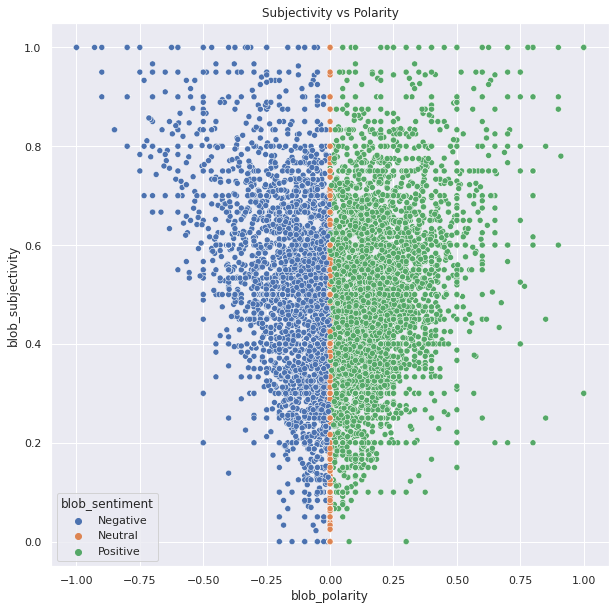

In [32]:
# Visualize the Polarity scores
plt.figure(figsize = (10, 10)) 
sns.scatterplot(x="blob_polarity", y="blob_subjectivity", hue="blob_sentiment", data=tweets)
plt.title("Subjectivity vs Polarity")
plt.show()

It seems that the most subjective tweets are also the most polarized. But the lexicon-based analysis is not always reliable, we have to check the results manually. So we are going to check the tweets with the highest polarity.

In [33]:
display(tweets.sort_values(by=["blob_polarity"], axis=0, ascending=False)[["tweet", "blob_polarity"]].head(20))

,tweet,blob_polarity
created_at,,
2020-07-15 08:11:15,in all the paperwork they ll have you sign ask them about the possibility of an esi causing arachnoiditis have you tried the meds that specifically target nerves ie lyrica neurontin best of luck to you,1.0
2020-11-10 07:16:01,yuk have had them they suck hope your doc ordered some neurontin neither aspirin not tylenol help w nerve pain wish you the best been there done that,1.0
2021-05-16 21:01:55,no benefit to outpatient post cd gabapentin regimen best paper competition,1.0
2021-03-23 20:53:18,patients aren t being informed period gabapentinoids are a perfect exandle,1.0
2021-06-12 12:18:15,ah yes coffee gabapentin and a cigarette or or the perfect starter kit,1.0
2021-05-01 17:04:48,helen pass presenting on best papers gabapentin should not be used in eras protocols,1.0
2019-05-01 11:15:31,increasing use of gabapentinoids perpetuates a bias towards the pharmacological management of pain goodman and brett cited by prof george peat in excellent cprd study summary in oral abstract session,1.0
2018-07-04 05:50:01,doctors should worry about whether gabapentinoids are the best drugs for any given patient politicians should stay out of it,1.0
2021-06-15 11:32:20,prozac and gabapentin are a wonderful combination,1.0


The reason why these tweets have the highest polarity is because they include positive terms like 'best', 'excellent' or 'great', but very few of the tweets express a positive opinion about gabapentinoids. 

Now we are going to repeat the process using Vader Sentiment.

In [34]:
sid = SentimentIntensityAnalyzer()

tweets['vader_scores'] = tweets['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))

tweets[['id', 'tweet', 'blob_polarity', 'blob_subjectivity', 'blob_sentiment', 'vader_scores']].sample(5)

,id,tweet,blob_polarity,blob_subjectivity,blob_sentiment,vader_scores
created_at,,,,,,
2021-06-29 11:49:27,1409811238763347974,im not a medic but if your mate is taking certain medication atm or about to start taking it possibly even something called pregabalin lyrica he should reconsider as it may be causing him extreme mental anxiety hopelessness sounds crazy i know just putting it out there,-0.122143,0.734286,Negative,"{'neg': 0.203, 'neu': 0.751, 'pos': 0.046, 'compound': -0.8739}"
2021-06-27 14:13:45,1409122780008886274,they will stop at nothing in order to peddle their toxic drugs no scruples no morals drs by now know the dangers of lyrica and neurontin so we need to sue them for rx this s,0.000000,0.000000,Neutral,"{'neg': 0.183, 'neu': 0.771, 'pos': 0.046, 'compound': -0.6919}"
2021-05-02 14:26:22,1388832233251872768,precisely ive been looking into it because i have chronic pain they wanted to give me gabapentin at my doctors office like a boat load of gabapentin sorry but ill take weed over a drug thats proven to make elderly patients sicker,-0.200000,0.933333,Negative,"{'neg': 0.15, 'neu': 0.813, 'pos': 0.037, 'compound': -0.6428}"
2021-05-27 16:42:40,1397926230205239311,this is a really a wonderful read so far ive read about half thank you ill have to finish reading this study later for now its gabapentin but more options are always coming,0.155556,0.611111,Positive,"{'neg': 0.053, 'neu': 0.83, 'pos': 0.117, 'compound': 0.3268}"
2020-06-19 15:23:52,1273969752671752192,ok highly doubt anyone actually reads this but curious relentless back pain x7 tried cbd norco neurontin steroid injections in my back nothing helping it has nothing to do with the cancer i have or nothing surgical required i had a ct and mri 2,0.093333,0.356667,Positive,"{'neg': 0.252, 'neu': 0.648, 'pos': 0.1, 'compound': -0.8985}"


Let's categorize the compound values:

In [35]:
tweets['vader_polarity'] = tweets['vader_scores'].apply(lambda score_dict: score_dict['compound'])

def analyse_compound(compound):
    if compound > 0:
        return "Positive"
    if compound == 0:
        return "Neutral"
    if compound < 0:
        return "Negative"
    
tweets["vader_sentiment"] = tweets['vader_polarity'].apply(analyse_compound)

tweets[['blob_polarity', 'blob_subjectivity', 'blob_sentiment', 'vader_scores', 'vader_sentiment']].head()

,blob_polarity,blob_subjectivity,blob_sentiment,vader_scores,vader_sentiment
created_at,,,,,
2011-01-29 01:35:33,0.0,0.0,Neutral,"{'neg': 0.0, 'neu': 0.567, 'pos': 0.433, 'compound': 0.7269}",Positive
2011-01-29 01:36:01,0.0,0.0,Neutral,"{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.4215}",Positive
2011-01-29 01:42:27,0.0,0.0,Neutral,"{'neg': 0.0, 'neu': 0.838, 'pos': 0.162, 'compound': 0.4767}",Positive
2011-01-29 01:54:33,0.0,0.0,Neutral,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'compound': 0.7003}",Positive
2011-01-29 01:58:40,0.0,0.0,Neutral,"{'neg': 0.0, 'neu': 0.78, 'pos': 0.22, 'compound': 0.4767}",Positive


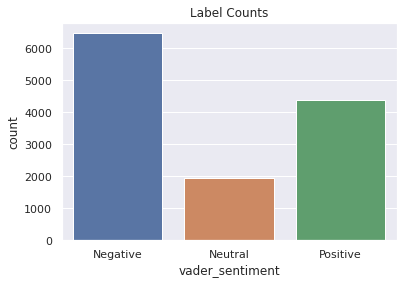

In [36]:
tweets["vader_sentiment"] = tweets["vader_sentiment"].astype("category")

sns.countplot(x=tweets["vader_sentiment"])
plt.title("Label Counts")
plt.show()

Vader sentiment has classified more tweets as negative. Let's see what punctuation gives to the tweets with the highest polarity.

In [37]:
display(tweets.sort_values(by=["blob_polarity"], axis=0, ascending=False)[["tweet", "vader_polarity", 'blob_polarity']].head(20))

,tweet,vader_polarity,blob_polarity
created_at,,,
2020-07-15 08:11:15,in all the paperwork they ll have you sign ask them about the possibility of an esi causing arachnoiditis have you tried the meds that specifically target nerves ie lyrica neurontin best of luck to you,0.7783,1.0
2020-11-10 07:16:01,yuk have had them they suck hope your doc ordered some neurontin neither aspirin not tylenol help w nerve pain wish you the best been there done that,0.3274,1.0
2021-05-16 21:01:55,no benefit to outpatient post cd gabapentin regimen best paper competition,0.4059,1.0
2021-03-23 20:53:18,patients aren t being informed period gabapentinoids are a perfect exandle,0.5719,1.0
2021-06-12 12:18:15,ah yes coffee gabapentin and a cigarette or or the perfect starter kit,0.7506,1.0
2021-05-01 17:04:48,helen pass presenting on best papers gabapentin should not be used in eras protocols,0.6369,1.0
2019-05-01 11:15:31,increasing use of gabapentinoids perpetuates a bias towards the pharmacological management of pain goodman and brett cited by prof george peat in excellent cprd study summary in oral abstract session,0.0000,1.0
2018-07-04 05:50:01,doctors should worry about whether gabapentinoids are the best drugs for any given patient politicians should stay out of it,0.3182,1.0
2021-06-15 11:32:20,prozac and gabapentin are a wonderful combination,0.5719,1.0


We can see that most of the tweets with the highest blob polarity also have a high vader polarity.

Now we repeat the process using flair

In [38]:
classifier = TextClassifier.load('en-sentiment')

2021-07-13 11:01:48,076 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


In [39]:
def flair_get_score_tweet(text):
  if not text:
    return 0
  s = Sentence(text)
  classifier.predict(s)
  value = s.labels[0].to_dict()['value'] 
  if value == 'POSITIVE':
    result = s.to_dict()['labels'][0]['confidence']
  else:
    result = -(s.to_dict()['labels'][0]['confidence'])
  return round(result, 3)

def sentiment_analysis_flair(polarity):
  if polarity > 0:
    return 'Positive'
  if polarity == 0:
    return 'Neutral'
  if polarity < 0:
    return 'Negative'

In [40]:
tweets['flair_score'] = tweets['tweet'].apply(flair_get_score_tweet)

tweets['flair_sentiment'] = tweets['flair_score'].apply(sentiment_analysis_flair)

tweets[['tweet', 'blob_sentiment', 'vader_sentiment', 'flair_sentiment']].sample(5)

,tweet,blob_sentiment,vader_sentiment,flair_sentiment
created_at,,,,
2018-02-16 22:33:44,looks like theyre going after gabapentinoids though those are used for pain as well how is it moral to take pain medications away and not have affordable replacements,Neutral,Negative,Negative
2019-08-23 22:34:29,unisom will help too it s a first gen anti histamine that is what makes you sleepy in nyquil klonopin works great too but is addictive and can leave you groggy the next day if you take too much try the neurontin lemme know of a po box if you need any it s expensive,Positive,Negative,Positive
2021-06-16 10:02:35,this is why conservative management didn t really work this is why ibuprofen and paracetamol have barely touched the sides and the ibu has reflux side effects but my pregabalin helps half the pain because it s a bloody nerve,Negative,Negative,Negative
2021-06-20 21:20:32,administering gabapentin along with antivirals may offer relief of,Neutral,Positive,Positive
2020-10-27 21:07:24,dont worry you guys arent missing out on much at best oral analgesics maybe confer marginal improvement in pain at best and gabapentinoids have not been shown in rcts to improve sciatica compressed nerve root related pain,Positive,Positive,Negative


Flair takes a long time to process all tweets, so I'm going to save the results in a csv file to save time.

In [41]:
tweets.to_csv('tweets.csv')

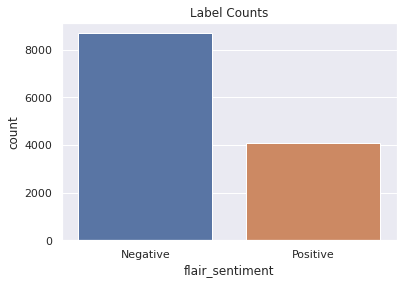

In [42]:
tweets["flair_sentiment"] = tweets["flair_sentiment"].astype("category")

sns.countplot(x=tweets["flair_sentiment"])
plt.title("Label Counts")
plt.show()

We see that flair classifies tweets only as positive or negative. We also see that the same tweet can be classified as positive, neutral or negative depending of the method we use. Let's see the percentage of times these algorithms agree with one another when classifying the sentiment of a tweet.

In [14]:
from sklearn.metrics import accuracy_score

print(f"Consensus TextBlob - VADER: {accuracy_score(tweets['blob_sentiment'],tweets['vader_sentiment']):.4}")
print(f"Consensus TextBlob - Flair: {accuracy_score(tweets['blob_sentiment'],tweets['flair_sentiment']):.4}")
print(f"Consensus VADER - Flair: {accuracy_score(tweets['vader_sentiment'],tweets['flair_sentiment']):.4}")

Consensus TextBlob - VADER: 0.5325
Consensus TextBlob - Flair: 0.3942
Consensus VADER - Flair: 0.5507


The two methods with the highest consensus are Vader and Flair, followed by TextBlob and VADER.

In [21]:
tweets = pd.read_csv('tweets.csv')

tweets[['id', 'tweet', 'flair_sentiment']].sample(5)

,id,tweet,flair_sentiment
6056,1306354789324926976,perioperative use of gabapentinoids for the management of postoperative acute pain a systematic review and meta analysis,Positive
11420,1403624953270833165,cyanoacetamide cas no 107 91 5 application pharmaceutical pregabalin intermediate allopurinol dye and plating solution intermediates weifang yukai chemical co ltd shandong fengfan chemical co ltd tel 86 536 8865335 website,Positive
11064,1402371785937412098,pharmacist we are out of stickers manager how why pharmacist somebody refilled gabapentin,Negative
11411,1403574597677682689,and now muscle spasms great love gabapentin first it kick started depressive thoughts a couple other issues and now spasms nothing but upsides,Positive
1439,933467658099363840,this includes meds we dont watch on a population level like gabapentinoids n,Negative


In [23]:
def consensus(row):
    count = 0
    count += row['blob_sentiment']==row['vader_sentiment']
    count += row['blob_sentiment']==row['flair_sentiment']
    count += row['vader_sentiment']==row['flair_sentiment']

    return count

tweets['consensus'] = tweets.apply(lambda row: consensus(row), axis=1)

tweets['consensus'].value_counts()

1    7991
3    3637
0    1166
Name: consensus, dtype: int64

We have almost 4000 tweets with the same sentiment for all three methods, and almost 8000 classified with the same sentiment by two methods.

In [25]:
all_three = tweets[tweets['consensus'] == 3]

all_three[['id', 'tweet', 'blob_sentiment', 'vader_sentiment', 'flair_sentiment']].sample(5)

,id,tweet,blob_sentiment,vader_sentiment,flair_sentiment
7362,1384469162395721734,oh i had gabapentin after my last surgery for a couple of days but the fentanyl is the iv stuff so nice my sats dropped on it as i was so high nurses actual words i forgot how to breathe so i had to have oxygen for a day hope you get home soon x,Positive,Positive,Positive
11454,1403833150325682176,i ve seen several people say this i m not taking it the other medication is gabapentin that one also decreases sex drive and makes it so you can t orgasm idk what to do,Negative,Negative,Negative
4161,1204467391046000640,feeling something from morning dose of neurontin i am thrilled if it s not the entire dose it s at least something,Positive,Positive,Positive
6573,1343966392089890817,associations between gabapentinoids and suicidal behaviour unintentional overdoses injuries road traffic incidents and violent crime population based cohort study in sweden the bmj,Negative,Negative,Negative
4698,1218365299310911493,ill look up neurontin never heard of it this pain is unbelievable i go in monday hopefully ill have more answers then,Negative,Negative,Negative


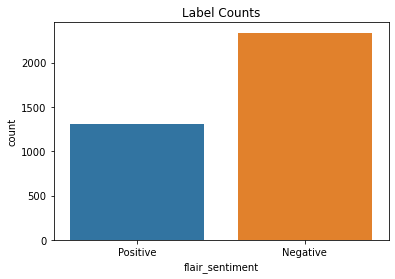

In [7]:
sns.countplot(x=all_three["flair_sentiment"])
plt.title("Label Counts")
plt.show()

We can see that, when all three methods agree, they classify most of the tweets as negative. Let's see what happen when only two methods agree. First, we check the tweets where VADER and Flair agree.

In [26]:
just_two = tweets[tweets['consensus'] == 1]

vader_flair = just_two[just_two['vader_sentiment'] == just_two['flair_sentiment']]

vader_flair[['id', 'tweet', 'vader_sentiment', 'flair_sentiment']].sample(5)

,id,tweet,vader_sentiment,flair_sentiment
11195,1402797262208585729,tw suicidal ideation whn i ran out of gabapentin bc of poverty i immediately stated experiencing joint pain whn i ran out of topirimate my migraines came back trintellix my brain chatter and suicidal ideation came back do not throw ur meds away w o consulting a dr,Negative,Negative
9100,1393388859921158145,after years of gabapentin off label they still didnt go back to our charts and write epilepsy so pain patients forced onto this should still be considered to be purely pain patients thats fair and just,Negative,Negative
3263,1160659759042875394,yes i used to take neurontin for it,Positive,Positive
12062,1406886057241628675,if they offer you a combination of tramadol and gabapentin ask for something else i was on gaba for nerve pain and while it works well coming off it was absolutely nightmarish they never tell you that,Negative,Negative
9353,1394761879856238597,hopefully my gabapentin weed bath will help,Positive,Positive


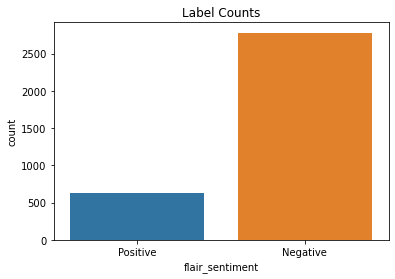

In [9]:
sns.countplot(x=vader_flair["flair_sentiment"])
plt.title("Label Counts")
plt.show()

When VADER and Flair agree, most of the tweets are classified as negative. Let's see what happen when TextBlob and VADER agree.

In [27]:
blob_vader = just_two[just_two['blob_sentiment'] == just_two['vader_sentiment']]

blob_vader[['id', 'tweet', 'blob_sentiment', 'vader_sentiment']].sample(5)

,id,tweet,blob_sentiment,vader_sentiment
427,227961387526258689,depomed announces publication of phase data from gralise gabapentin,Neutral,Neutral
4527,1212919652331880454,true even though i am allergic to lyrica and neurontin pain doctor prescribed gabapentin even though my allergies are documented and i was so sick i had to stay in bed for weeks gabapentin is an anti convulsive terrible drug,Negative,Negative
8756,1391677622686420992,taking gabapentin and xanax this fine morning so i dissociate thru this godforsaken shift,Positive,Positive
10460,1399641402737414144,i bet you could sleep all day i take codeine times a day and morphine twice and pregabalin twice and people wonder why i sleep every afternoon hope your ankle feels better soon and hope you haven t broken it or anything,Positive,Positive
11599,1404584589339807744,thanks very much i appreciate it and i changed me mind last min and had gabapentin im scared ahhahaha,Positive,Positive


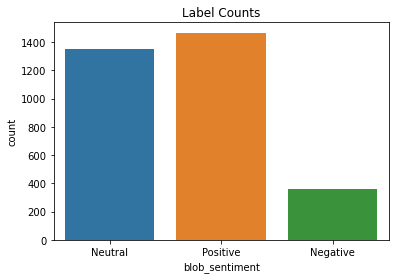

In [28]:
sns.countplot(x=blob_vader["blob_sentiment"])
plt.title("Label Counts")
plt.show()

TextBlob and VADER have a 'Neutral' category, and TextBlob classifies most of the tweets as 'Positive' and 'Neutral', so we see the same results when both methods agree. Now let's check the tweets where TextBlob and Flair agree.

In [29]:
blob_flair = just_two[just_two['blob_sentiment'] == just_two['flair_sentiment']]

blob_flair[['id', 'tweet', 'blob_sentiment', 'flair_sentiment']].sample(5)

,id,tweet,blob_sentiment,flair_sentiment
2285,1126305439979716608,some of the knock offs are pretty awful i am glad i found them and would hate to be without them but i know not every treatment option works well for everybody i also take mg neurontin among several other meds everyday and have no ill effects not everybody can take it,Negative,Negative
8166,1388355762943102976,wow im on gabapentin off and on for years my memory is also really bad thank you for sharing this info,Negative,Negative
12171,1407412204874338305,i can only sleep well if i ve taken mg of neurontin i sleep like a baby but if i run out fuggetaboutit up and down all night long,Negative,Negative
8292,1388935700196864001,me too and my dog with severe arthritis who passed away last year was on them took him off all the vet medication which is also used to medicate humans e g gabapentin on advice from a retired vet and moved him to these new lease of life limping stopped,Positive,Positive
10427,1399543891477606401,also ask about gabapentin inexpensive and a good long term pain med,Positive,Positive


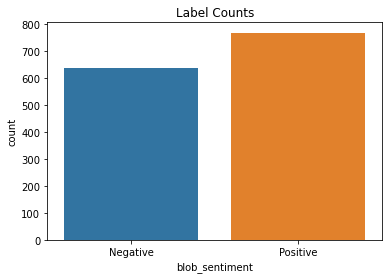

In [30]:
sns.countplot(x=blob_flair["blob_sentiment"])
plt.title("Label Counts")
plt.show()

The number of positive and negative tweets is almost the same.

<h2>CONCLUSION</h2>

I think every method has its pros and cons. I also think that the results vary when we apply them to unprocessed text. I will try other methods and techniques for data gathering, data cleaning and text analysis.